<a href="https://colab.research.google.com/github/Alepescinaa/ScientificTools/blob/main/Project2/Cp3/Checkpoint3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flow and transport problem - SPE10

In this checkpoint we investigate the transport problem where the advective field is computed with a Darcy model.

Before creating the grid we import NumPy, the SciPy sparse library and PorePy.

In [ ]:
%%capture
!git clone https://github.com/Alepescinaa/ScientificTools
%cd ScientificTools/Project2/Cp3

!apt-get update
!apt-get install libglu1-mesa

!git clone https://github.com/pmgbergen/porepy.git
%cd porepy

!git checkout main

!pip install -r requirements.txt

!pip install .

%cd ..

In [ ]:
import os
import numpy as np
import porepy as pp
from tqdm import tqdm
import scipy.sparse as sps
import matplotlib.pyplot as plt

cwd_folder = os.getcwd()
spe10_folder = cwd_folder + "/spe10/"
import sys; sys.path.insert(1, spe10_folder)

from spe10 import Spe10

/usr/local/lib/python3.10/dist-packages/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


# Forward problem

We specify number of cells in each dimension and the physical size of the domain. Then we create a Cartesian grid and compute geometric properties such as face centers, cell volumes etc.

In [ ]:
selected_layers = 2

# Define the class with the corresponding layer(s)
spe10 = Spe10(selected_layers)
# For simplicity we extract the grid form the class spe10
sd = spe10.sd

# Read the permeability associated to the given layer(s)
perm_folder = spe10_folder + "/perm/"
spe10.read_perm(perm_folder)
perm_dict = spe10.perm_as_dict()

We declare the data for the Darcy problem.

In [ ]:
# Permeability
perm = pp.SecondOrderTensor(kxx=perm_dict["kxx"], kyy=perm_dict["kyy"], kzz=perm_dict["kzz"])
injection_rate = 1
pos_well = [216.40800000000002, 370.332]
  #this is the position found with the optimization
#it will be kept fixed

# Boundary conditions: homogeneous neumann everywhere
b_faces = sd.tags["domain_boundary_faces"].nonzero()[0]
b_face_centers = sd.face_centers[:, b_faces]
labels = np.array(["neu"] * b_faces.size)
bc_val = np.zeros(sd.num_faces)
bc = pp.BoundaryCondition(sd, b_faces, labels)

# Collect all parameters in a dictionary
parameters = {"second_order_tensor": perm, "bc": bc, "bc_values": bc_val}

We now set the data for the Darcy problem

In [ ]:
flow_key = "flow"
flow_data = pp.initialize_default_data(sd, {}, flow_key, parameters)

We now solve the Darcy problem by using the MPFA scheme.

In [ ]:
# construct the lhr and rhs from the discretization of the diffusion operator
mpfa = pp.Mpfa(flow_key)
mpfa.discretize(sd, flow_data)
A, b = mpfa.assemble_matrix_rhs(sd, flow_data)

# Add the injection wells, all with the same injection rate
b_wells = np.zeros_like(b)
index_iwells = [
   0,
   spe10.full_shape[0] - 1,
   spe10.full_shape[0] * spe10.full_shape[1] - spe10.full_shape[0],
   spe10.full_shape[0] * spe10.full_shape[1] - 1,
   ]
b_wells[index_iwells] = injection_rate

# Add the production well by using a Lagrange multiplier, first we identify the cell
ij_well = np.floor( (np.asarray(pos_well) / spe10.spacing[:-1])).astype(int)
index_pwell = spe10.full_shape[0] * ij_well[1] + ij_well[0]
vect = np.zeros((sd.num_cells, 1))
vect[index_pwell] = 1

# Solve the linear system and compute the pressure by adding the constraint
A = sps.bmat([[A, vect], [vect.T, None]], format="csc")
b = np.append(b + b_wells, 0)
cell_p = sps.linalg.spsolve(A, b)[:-1]

# now data contains the discretization matrices build from MPFA
mat_discr = flow_data[pp.DISCRETIZATION_MATRICES][flow_key]

q = mat_discr["flux"] @ cell_p + mat_discr["bound_flux"] @ bc_val

And we export the corresponding solutions.

In [ ]:
# to export the flux
mvem = pp.MVEM(flow_key)
mvem.discretize(sd, flow_data)

# construct the P0 flux reconstruction
cell_q = mvem.project_flux(sd, q, flow_data)

save = pp.Exporter(sd, "sol_p", folder_name="transport")

data_to_export = [("kxx", np.log10(perm_dict["kxx"])),
                  ("kyy", np.log10(perm_dict["kyy"])),
                  ("kzz", np.log10(perm_dict["kzz"])),
                  ("cell_p", cell_p),
                  ("cell_q", cell_q)]
save.write_vtu(data_to_export)

We now consider the transport problem where now the advective field is the one computed from the Darcy problem. First we set the data.

In [ ]:
# Transport problem
transport_key = "transport"
delta_t = 500
num_steps = 200

# boundary conditions for the advection problem: no flow everywhere
labels = np.array(["neu"] * b_faces.size)
bc_val = np.zeros(sd.num_faces)
bc = pp.BoundaryCondition(sd, b_faces, labels)

parameters = {"darcy_flux": q, "bc": bc, "bc_values": bc_val}
transport_data = pp.initialize_default_data(sd, {}, transport_key, parameters)

As done in the other cases, we now construct the upwind matrix and the mass matrix.

In [ ]:
# create the upwind and mass matrices
upwind = pp.Upwind(transport_key)  #the problem is linear, upwind flux is fine (a bit diffusive)

# discretize and get the matrices
upwind.discretize(sd, transport_data)

U, b_upwind = upwind.assemble_matrix_rhs(sd, transport_data)

M = sps.csr_matrix(np.diag(sd.cell_volumes), shape=np.shape(U))


Finally, by using the implicit Euler we compute the concentration that is transported in the porous medium

initial mass 2675.6075520000013
total outflow 2473.2124642670915
mass trapped in the domain 202.3950877329109
error in mass conservation -1.0800249583553523e-12


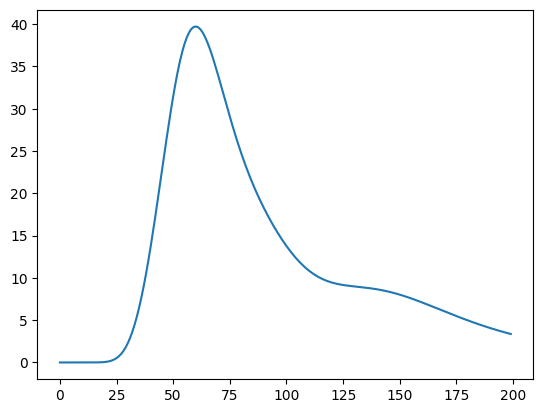

In [ ]:
# Initial condition: we have zero concentration except for a small square. The position of this square
# is what we aim to find to match the curve measured at the well

initial_conc_pos = [58,603]  # [292,505] #[300,400]
L = 50

ini_cond = np.logical_and((np.abs(sd.cell_centers[0,:]-initial_conc_pos[0])<L/2),(np.abs(sd.cell_centers[1,:]-initial_conc_pos[1])<L/2))
c = np.zeros(sd.num_cells)
c[ini_cond] = 1

initial_mass = np.sum(c*sd.cell_volumes) #total mass. This is the max we can collect at the well over time

#export initial condition
save = pp.Exporter(sd, "sol_c", folder_name="transport")
save.write_vtu([("conc", c)], time_step=0)

# IE with LU factorization
S = M + delta_t * U

# this part is a bit tricky: at the production well I chose to enforce zero concentration or, if you want,
# infinite storage volume. This is because flow and concentration flux should be able to exit the cell to mimic
# a production well.

# like for pressure, this is done with a Lagrange multiplier, adding a row and a column
S = sps.bmat([[S, vect], [vect.T, None]], format="csc")

outflow = [] #this is to store the flow exiting from the well in time
#the matrix will not change so it is convenient to factorize it once and for all
lu = sps.linalg.splu(S.tocsc())

for i in np.arange(num_steps):
    b = M @ c + delta_t * b_upwind
    b = np.append(b,0)
    sol = lu.solve(b)
    c = sol[:-1]
    ll = sol[-1] #this is the Lagrange multiplier and represents the flux exiting from the "well"
    save.write_vtu([("conc", c)], time_step=(i+1)*delta_t)
    outflow.append(ll)

plt.plot(np.arange(num_steps),outflow)
# export the main pvd file
time = np.arange((num_steps+1))*delta_t
save.write_pvd(time)

# let's check: mass conservation

total_outflow = np.sum(outflow)
final_internal_mass = np.sum(c*sd.cell_volumes)

print('initial mass', initial_mass)
print('total outflow', total_outflow)
print('mass trapped in the domain', final_internal_mass)

print('error in mass conservation',initial_mass-total_outflow-final_internal_mass) #must be 0 or machine eps.

In [ ]:
def compute_conc(coord):

    initial_conc_pos = coord
    L = 50

    ini_cond = np.logical_and((np.abs(sd.cell_centers[0,:]-initial_conc_pos[0])<L/2),(np.abs(sd.cell_centers[1,:]-initial_conc_pos[1])<L/2))
    c = np.zeros(sd.num_cells)
    c[ini_cond] = 1

    outflow = []
    lu = sps.linalg.splu(S.tocsc())

    for i in np.arange(num_steps):
        b = M @ c + delta_t * b_upwind
        b = np.append(b,0)
        sol = lu.solve(b)
        c = sol[:-1]
        ll = sol[-1]
        outflow.append(ll)

    return np.array(outflow).reshape(1,200)

In [ ]:
def sampling(step,layer,well_pos):

    spacing_fine = np.asarray(spe10.full_physdims[:-1])/np.asarray(spe10.full_shape[:-1])

    x = spacing_fine[0] / 2 + spacing_fine[0] * np.arange(spe10.full_shape[0])
    y = spacing_fine[1] / 2 + spacing_fine[1] * np.arange(spe10.full_shape[1])

    X , Y = np.meshgrid(x,y)

    coord = np.vstack((X.flatten(), Y.flatten())).T
    coord_coarse = coord[::step,:]

    # conc contains all the curves for every point
    n = coord_coarse.shape[0]
    conc = np.zeros((n,200))

    for i in tqdm(range(n)):
        conc[i,:] = compute_conc(coord[i,:])

    np.save('data_conc_' + str(layer) + '.npy', conc)
    np.save('data_coord_' + str(layer) + '.npy', coord_coarse)

    return conc, coord_coarse

In [ ]:
conc, coord_coarse = sampling(4, selected_layers, pos_well)

100%|██████████| 3300/3300 [19:51<00:00,  2.77it/s]


In [ ]:
import matplotlib.pyplot as plt

# Assuming `conc` is your data array and `coord_coarse` is your coordinate array
num_plots = conc.shape[0]
num_columns = 5
num_rows = -(-num_plots // num_columns)  # Ceiling division to determine number of rows

fig, axs = plt.subplots(num_rows, num_columns, figsize=(4 * num_columns, 4 * num_rows))

for i in range(num_plots):
    row = i // num_columns
    col = i % num_columns
    axs[row, col].plot(np.arange(num_steps), conc[i])
    axs[row, col].set_title(f'Initial conc in {coord_coarse[i]}')

# Hide any unused subplots
for i in range(num_plots, num_rows * num_columns):
    row = i // num_columns
    col = i % num_columns
    fig.delaxes(axs[row, col])

plt.tight_layout()
plt.show()

# Surrogate NN

In [ ]:
!pip install tensorflow==2.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 34.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
import random
import tensorflow as tf
import tensorflow.keras as tfk
import scipy.optimize as optimize
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras import layers, models, regularizers, constraints

In [ ]:
print(tf.__version__)

2.16.1


In [ ]:
def build_surrogate(input_shape):

    inputs = tf.keras.layers.Input(shape=input_shape, name='Input')

    x = tf.keras.layers.Dense(32,activation = 'relu')(inputs)
    x = tf.keras.layers.Dense(64,activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(x)
    x = tf.keras.layers.Dense(128,activation = 'relu')(x)
    x = tf.keras.layers.Dense(256,activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(x)
    x = tf.keras.layers.Dense(512,activation = 'relu')(x)
    x = tf.keras.layers.Dense(1024,activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(x)
    x = tf.keras.layers.Dense(2048,activation = 'relu')(x)
    x = tf.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(1024,activation = 'relu')(x)
    x = tf.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(512,activation = 'relu')(x)
    x = tf.keras.layers.Dense(256,activation = 'relu')(x)

    output = tf.keras.layers.Dense(200, activation = 'linear', kernel_constraint = constraints.NonNeg())(x)

    model = tf.keras.Model(inputs, output)

    return model

In [ ]:
outflow = np.zeros((200,))


coord_2 = np.load('data/data_coord_2.npy')
coord_2 = coord_2[::4]
Y_2 = np.load('data/data_conc_2.npy')
Y_2 = Y_2[::4]

coord_12 = np.load('data/data_coord_12.npy')
coord_12 = coord_12[::4]
Y_12 = np.load('data/data_conc_12.npy')
Y_12 = Y_12[::4]

coord_20 = np.load('data/data_coord_20.npy')
coord_20 = coord_20[::4]
Y_20 = np.load('data/data_conc_20.npy')
Y_20 = Y_20[::4]

coord_42 = np.load('data/data_coord_42.npy')
coord_42 = coord_42[::4]
Y_42 = np.load('data/data_conc_42.npy')
Y_42 = Y_42[::4]

coord_51 = np.load('data/data_coord_51.npy')
coord_51 = coord_51[::4]
Y_51 = np.load('data/data_conc_51.npy')
Y_51 = Y_51[::4]

coord_71 = np.load('data/data_coord_71.npy')
coord_71 = coord_71[::4]
Y_71 = np.load('data/data_conc_71.npy')
Y_71 = Y_71[::4]

coord_82 = np.load('data/data_coord_82.npy')
coord_82 = coord_82[::4]
Y_82 = np.load('data/data_conc_82.npy')
Y_82 = Y_82[::4]

coord = np.vstack((coord_2, coord_12, coord_20, coord_42, coord_51, coord_71, coord_82))


selected_layers = 2
spe10 = Spe10(selected_layers)
perm_folder = spe10_folder + "/perm/"
spe10.read_perm(perm_folder)
perm_dict = spe10.perm_as_dict()
perm_values_2 = perm_dict['kxx']
perm_values_2 = perm_values_2[::4]

selected_layers = 12
spe10 = Spe10(selected_layers)
perm_folder = spe10_folder + "/perm/"
spe10.read_perm(perm_folder)
perm_dict = spe10.perm_as_dict()
perm_values_12 = perm_dict['kxx']
perm_values_12 = perm_values_12[::4]

selected_layers = 20
spe10 = Spe10(selected_layers)
perm_folder = spe10_folder + "/perm/"
spe10.read_perm(perm_folder)
perm_dict = spe10.perm_as_dict()
perm_values_20 = perm_dict['kxx']
perm_values_20 = perm_values_20[::4]

selected_layers = 42
spe10 = Spe10(selected_layers)
perm_folder = spe10_folder + "/perm/"
spe10.read_perm(perm_folder)
perm_dict = spe10.perm_as_dict()
perm_values_42 = perm_dict['kxx']
perm_values_42 = perm_values_42[::4]

selected_layers = 51
spe10 = Spe10(selected_layers)
perm_folder = spe10_folder + "/perm/"
spe10.read_perm(perm_folder)
perm_dict = spe10.perm_as_dict()
perm_values_51 = perm_dict['kxx']
perm_values_51 = perm_values_51[::4]

selected_layers = 71
spe10 = Spe10(selected_layers)
perm_folder = spe10_folder + "/perm/"
spe10.read_perm(perm_folder)
perm_dict = spe10.perm_as_dict()
perm_values_71 = perm_dict['kxx']
perm_values_71 = perm_values_71[::4]

selected_layers = 82
spe10 = Spe10(selected_layers)
perm_folder = spe10_folder + "/perm/"
spe10.read_perm(perm_folder)
perm_dict = spe10.perm_as_dict()
perm_values_82 = perm_dict['kxx']
perm_values_82 = perm_values_82[::4]

pos_well_2 = [216.40800000000002, 370.332]
dist_2 = np.sqrt((coord_2[:,0]-pos_well_2[0])**2+(coord_2[:,1]-pos_well_2[1])**2)

pos_well_12 = [204.216, 550.1639999999999]
dist_12 = np.sqrt((coord_12[:,0]-pos_well_12[0])**2+(coord_12[:,1]-pos_well_12[1])**2)

pos_well_20 = [198.12, 217.93199999999993]
dist_20 = np.sqrt((coord_20[:,0]-pos_well_20[0])**2+(coord_20[:,1]-pos_well_20[1])**2)

pos_well_42 = [76.2, 446.53199999999987]
dist_42 = np.sqrt((coord_42[:,0]-pos_well_42[0])**2+(coord_42[:,1]-pos_well_42[1])**2)

pos_well_51 = [313.9440000000001, 598.9319999999999]
dist_51 = np.sqrt((coord_51[:,0]-pos_well_51[0])**2+(coord_51[:,1]-pos_well_51[1])**2)

pos_well_71 = [192.024, 574.5479999999999]
dist_71 = np.sqrt((coord_71[:,0]-pos_well_71[0])**2+(coord_71[:,1]-pos_well_71[1])**2)

pos_well_82 = [271.272, 41.147999999999996]
dist_82 = np.sqrt((coord_82[:,0]-pos_well_82[0])**2+(coord_82[:,1]-pos_well_82[1])**2)

dist = np.hstack((dist_2,dist_12,dist_20,dist_42,dist_51,dist_71,dist_82))

perm_values = np.hstack((perm_values_2,perm_values_12,perm_values_20,perm_values_42,perm_values_51,perm_values_71,perm_values_82))

tags = np.array([2, 12, 20, 42, 51, 71, 82])
tag = np.repeat(tags, 3300)

X = np.column_stack((coord, perm_values, dist, tag))
Y = np.vstack((Y_2,Y_12,Y_20,Y_42,Y_51,Y_71,Y_82))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 4768442)

NameError: name 'np' is not defined

In [ ]:
# outflow = np.zeros((200,))


# coord = np.load('data/data_coord_2.npy')
# Y = np.load('data/data_conc_2.npy')

# selected_layers = 12
# spe10 = Spe10(selected_layers)
# sd = spe10.sd
# perm_folder = spe10_folder + "/perm/"
# spe10.read_perm(perm_folder)
# perm_dict = spe10.perm_as_dict()
# perm_values=perm_dict['kxx']
# pos_well = [216.40800000000002, 370.332]
# dist=np.sqrt((coord[:,0]-pos_well[0])**2+(coord[:,1]-pos_well[1])**2)

# X = np.column_stack((coord, perm_values, dist))

# #Y_min = np.min(Y)
# #Y_max = np.max(Y)
# #Y_std = (Y-Y_min)/(Y_max-Y_min)

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=4768442)

In [ ]:

def weighted_mse(y_true, y_pred):
    weights = tf.where(
        tf.cast(tf.reduce_max(y_true, axis=-1, keepdims=True) - tf.reduce_min(y_true, axis=-1, keepdims=True), tf.float32) < 1.0,
        tf.constant(5.0, dtype=tf.float32),
        tf.constant(1.0, dtype=tf.float32)
    )
    squared_diff = tf.square(y_true - y_pred)
    weighted_squared_diff = squared_diff * weights
    return tf.reduce_mean(weighted_squared_diff, axis=-1)


In [ ]:
surrogate = build_surrogate((5,))
surrogate.summary()

optimizer = tfk.optimizers.AdamW(learning_rate = 1e-3)

surrogate.compile(optimizer=optimizer, loss= weighted_mse, metrics = ['mae'])

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor = 0.5, patience = 20),tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 40, restore_best_weights=True)]

surrogate.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 64, epochs = 1000 , callbacks = callbacks)

NameError: name 'build_surrogate' is not defined

In [ ]:
surrogate.save('model_tot1_step4_customloss.keras', save_format='keras')
#!zip -r model_tot1_step4.zip model_tot1_step4/

In [ ]:
{/content/ScientificTools/Project2/Cp3/Checkpoint3.md}

NameError: name 'path' is not defined

In [ ]:
tfk.models.save_model(surrogate,'/content/ScientificTools/Project2/Cp3/model_tot1_step4xale.keras')

In [ ]:
y_pred = surrogate.predict(X_test[4].reshape(1,5,))
mse = np.sqrt(np.mean((y_pred-y_test[4])**2))
mse

1/1 [==============================] - 0s 164ms/step


0.18747101278129483

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


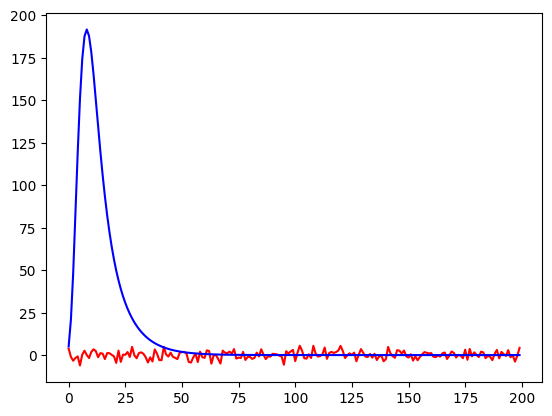

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


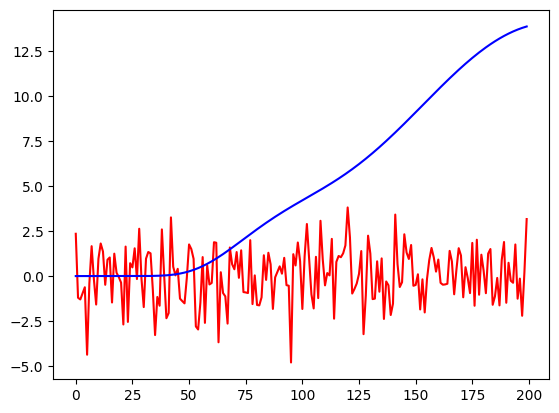

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


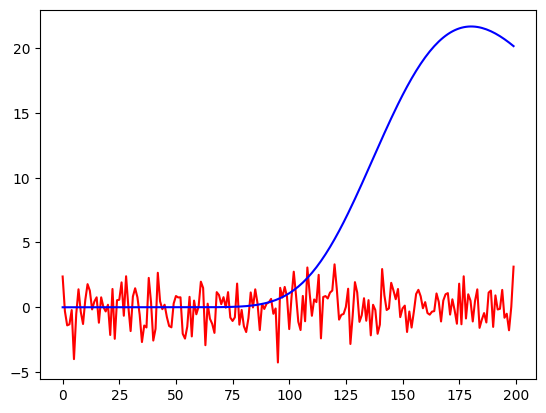

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


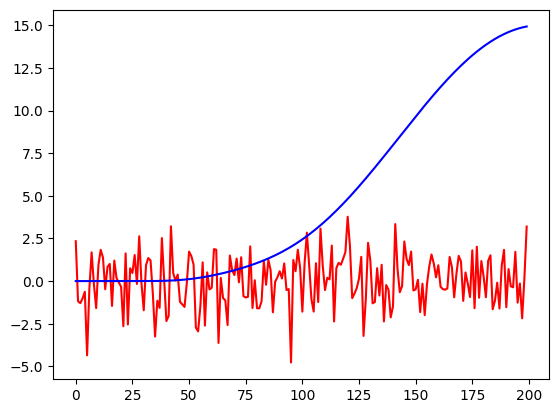

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


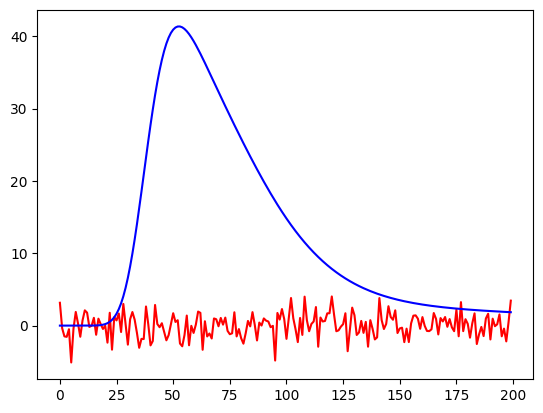

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


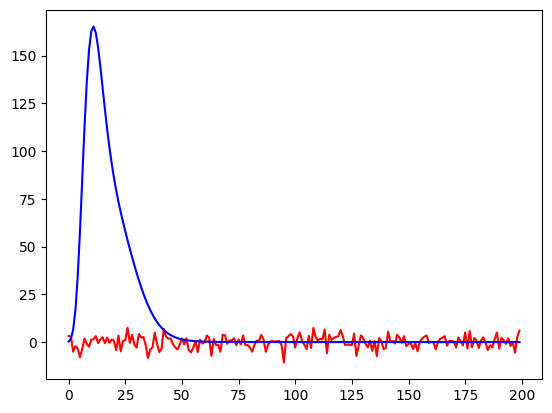

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


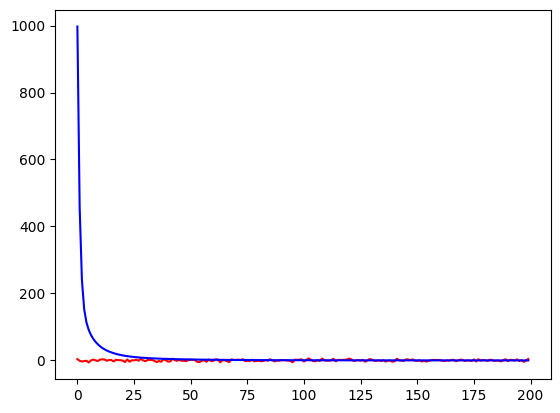

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


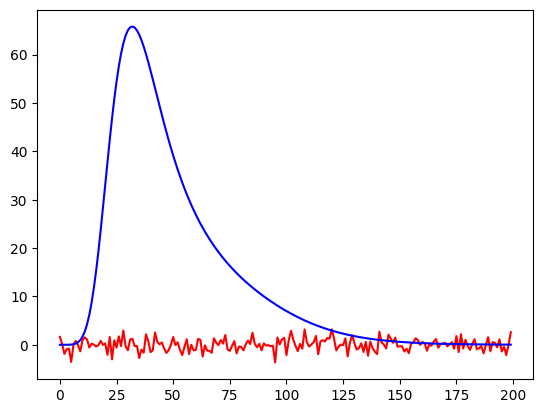

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


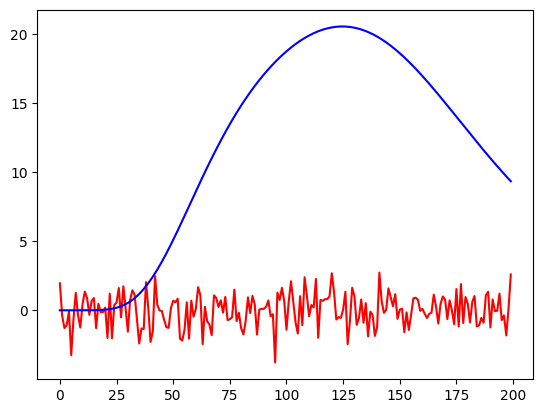

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


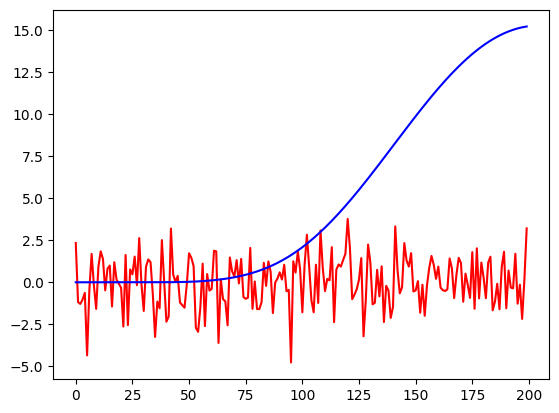

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


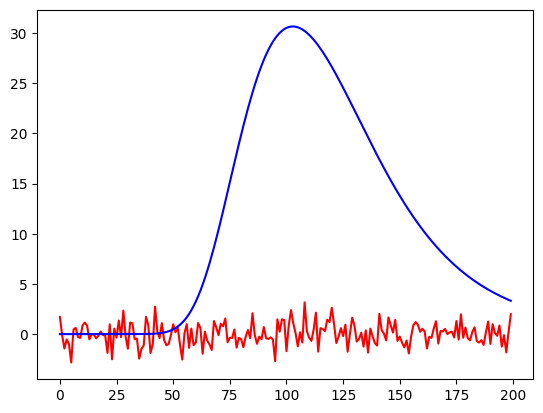

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


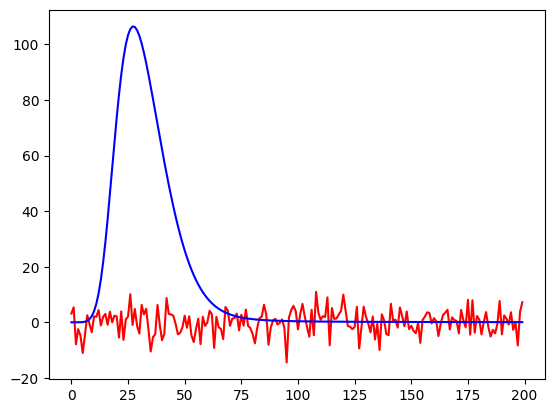

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


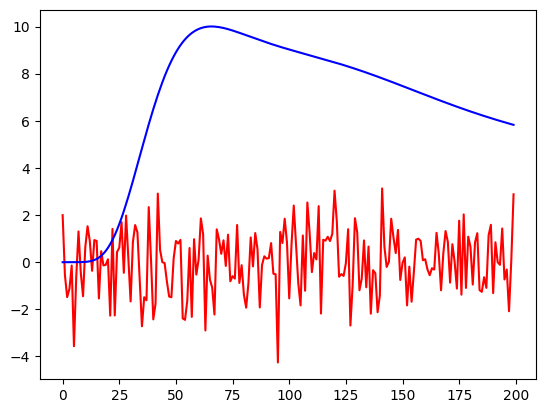

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


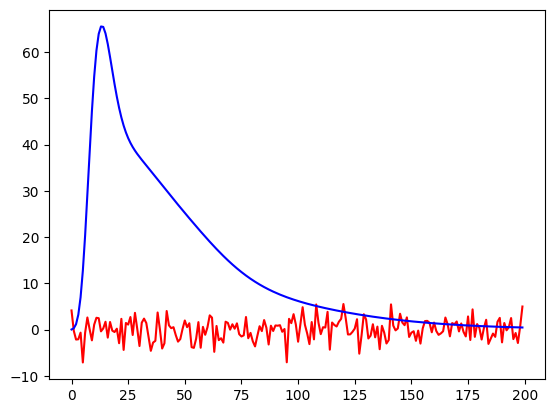

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


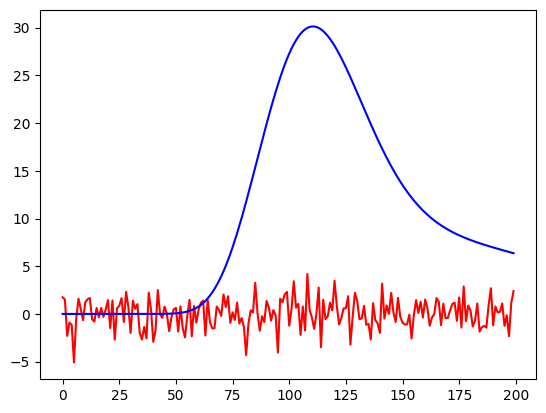

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


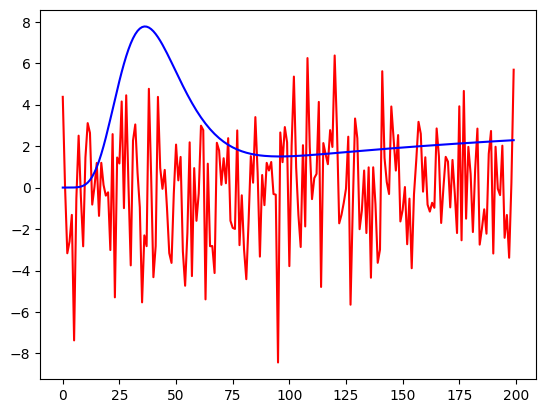

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


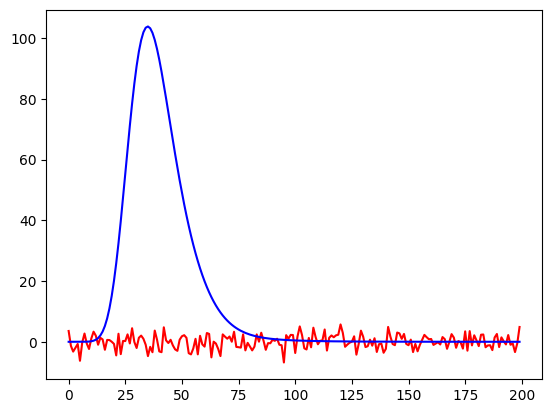

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


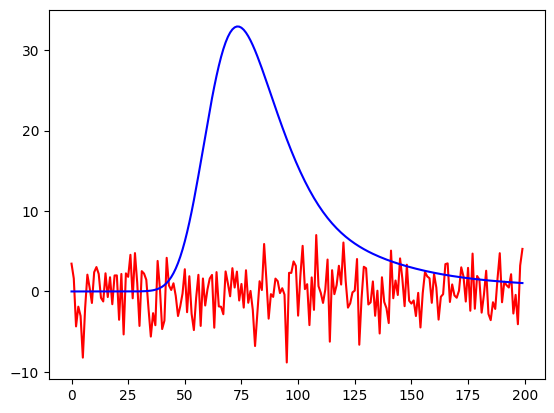

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


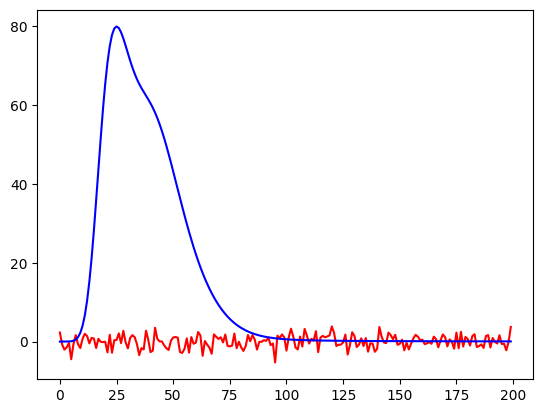

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


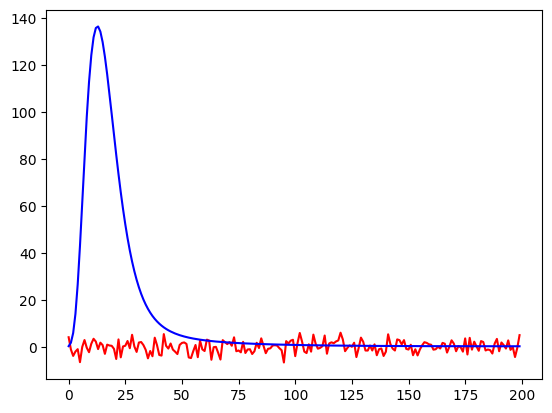

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


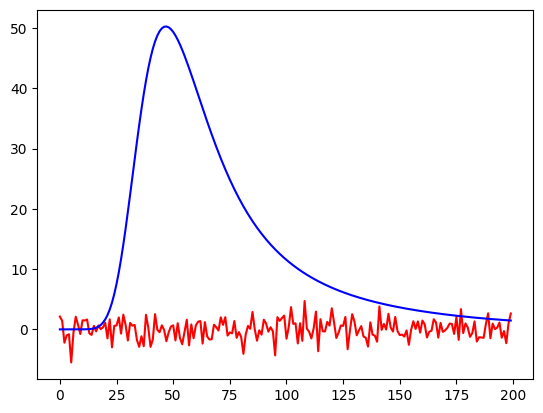

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


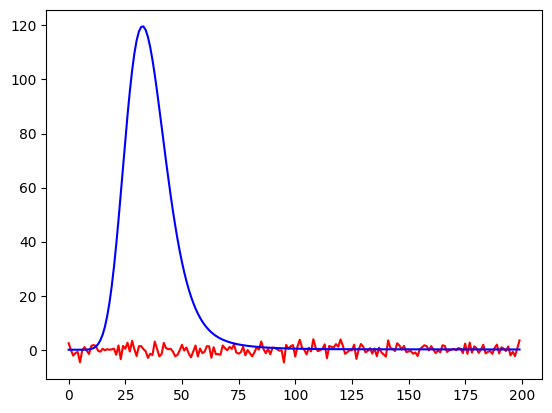

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


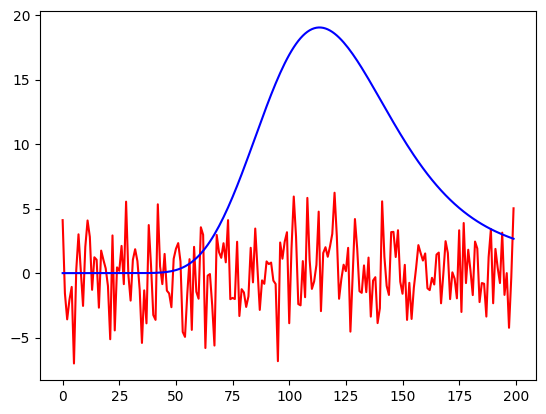

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


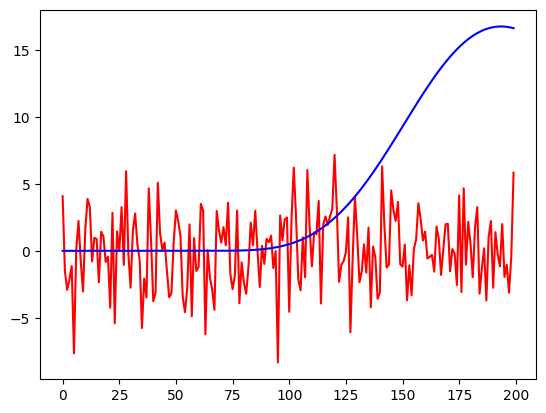

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


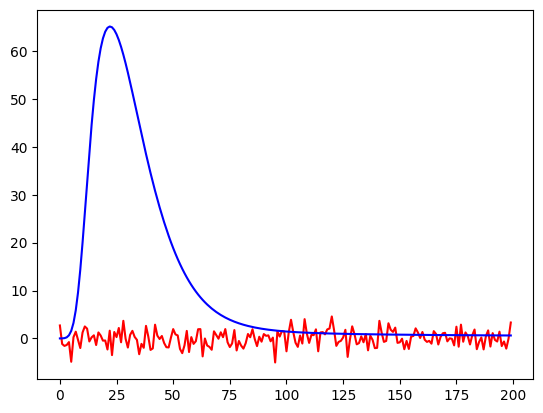

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


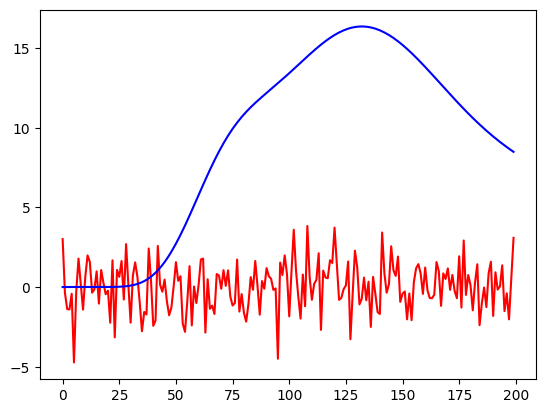

In [ ]:
idx = np.random.choice(range(y_test.shape[0]),50)
for i,j in enumerate(idx):

    y_pred = surrogate.predict(X_test[j].reshape(1,5,))

    plt.figure(i)
    plt.plot(range(200), y_pred.reshape(200,), 'r', range(200), y_test[j], 'b')
    plt.show()

In [ ]:
def Checkpoint3_solution(selected_layers,initial_conc_pos, L=50):

    outflow = np.zeros((200,))

    spe10 = Spe10(selected_layers)
    perm_folder = spe10_folder + "/perm/"
    spe10.read_perm(perm_folder)
    perm_dict = spe10.perm_as_dict()
    perm_values = perm_dict['kxx']

    i = np.floor(initial_conc_pos[0] / spe10.spacing[0])
    j = np.floor(initial_conc_pos[1] / spe10.spacing[1])
    index = int(i + spe10.full_shape[0] * j)

    if selected_layers == 2:
        pos_well = [216.40800000000002, 370.332]
    elif selected_layers == 12:
        pos_well = [204.216, 550.1639999999999]
    elif selected_layers == 20:
        pos_well = [198.12, 217.93199999999993]
    elif selected_layers == 42:
        pos_well = [76.2, 446.53199999999987]
    elif selected_layers == 51:
        pos_well = [313.9440000000001, 598.9319999999999]
    elif selected_layers == 71:
        pos_well = [192.024, 574.5479999999999]
    else:
        pos_well = [271.272, 41.147999999999996]

    dist = np.sqrt((initial_conc_pos[0] - pos_well[0]) ** 2 + (initial_conc_pos[1] - pos_well[1]) ** 2)
    X = np.column_stack((initial_conc_pos[0], initial_conc_pos[1], perm_values[index], dist, selected_layers))

    #model = load_model('/content/drive/MyDrive/model_tot1')
    outflow = model.predict(X)

    return outflow

In [ ]:
selected_layers = [51, 71, 42, 20, 12, 2, 82]

if __name__ == '__main__':

  for i in range(7):

     outflow = Checkpoint3_solution(selected_layers[i], [120, 250] )

1/1 [==============================] - 0s 28ms/step
